### Imports

In [1]:
import json
import sys
import pandas as pd
import random
import os
import operator
import numpy as np
import numpy.random
import netCDF4 as nc
import xarray as xr
import re
import pickle as pkl
import torch
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from torch.autograd import Variable
from math import radians, cos, sin, asin, sqrt
from torch.utils.data import Dataset
from datetime import datetime, timedelta
from time import time, strftime, gmtime

sys.path.append('/home/ninow/master_thesis/code/project/')
from utils.data import DataUtils
from utils import ModelUtils
from model import Baseline

### Define Helper Methods (methods from DataUtils.py)

In [2]:
# this dictionary can be used to get the days that have already passed for a certain month in year
passed_days_per_month_dict = {
    1 : 0,
    2 : 31,
    3 : 59,
    4 : 90,
    5 : 120,
    6 : 151,
    7 : 181,
    8 : 212,
    9 : 243,
    10 : 273,
    11 : 304,
    12 : 334
}
# transform filenames of type YYMMDDHH -> time
def getTimeFromFileName(file_names, lead=1):
    times = []
    for file_name in file_names:
        year = file_name[:2]
        month = file_name[2:4]
        day = file_name[4:6]
        hour = file_name[6:8]
        # by loading the observation data again for the init time, we need to add the lead time for the prediction
        dt = datetime(year=2000+int(year), month=int(month), day=int(day), hour=int(hour)) + timedelta(hours=lead)
        times += [np.datetime64(dt)]
    return times

# calculate the time [0,3,...,21] for which the label stands for
def getInversedHour(time_data, lead_idx):
    inversed_hour = []
    for l in lead_idx:
        x = np.arccos(time_data[l][0])
        if time_data[l][1] < 0:
            x = -x
            inversed_hour += [24 + int((x / (2 * np.pi)) * 24)]
        else:
            inversed_hour += [int((x / (2 * np.pi)) * 24)]
    return inversed_hour


# calculate the month [1,...,12] for which the label stands for
def getInversedMonth(time_data, lead_idx):
    inversed_month = []
    for l in lead_idx:
        x = np.arccos(time_data[l][2])
        if time_data[l][3] < 0:
            x = -x
            inversed_month += [12 + int((x / (2 * np.pi)) * 12) + 1]
        else:
            inversed_month += [int((x / (2 * np.pi)) * 12) + 1]
    return inversed_month


# calculates all raw COSMO-1 files, that have not yet been preprocessed,
# according all the preprocessed files in DESTINATION
def get_all_files(src_path, stations, inits):
    all_files = []

    # get all files from all the station folder if inis is None. In this case we are interested in the per
    # station and init time preprocessed single files.
    if inits is None:
        for s in stations:
            all_files += [(str(s), f[:-4]) for f in os.listdir(src_path + '/station_init/grid_size_9/' + 'Station_' + str(s))]
    # generate files according to all stations and init times that were found in the data set
    else:
        # the source path is not appended to reduce redundancy
        for s in stations:
            all_files += [(s, init) for init in inits]

    # only keep one file for each day and initialization time
    all_files = set(all_files)

    return all_files



# get all file paths for the stations under the given source path
def getFilesToProcess(ADDRESSdata, DESTINATION, Dates):

    # get all comso folders, representing one run (output) of the COSMO-1 model
    all_cosmo_folders = [(D[-12:-4], D[-4:]) for D in os.listdir(ADDRESSdata) if D[0] == '1' and D[-4] == '_']

    # return all files that have not yet been processed
    return [f[0] + f[1] for f in all_cosmo_folders if f[0] in Dates]

# loads the data statistics (min, max, mean, std) for each feature
# and adds the input parameters to the experiment configuration
def getDataStatistics(config):
    data_statistics = None
    # Load statistics from data set for feature scaling
    if config['is_normalization']:
        with open(config['input_source'] + "/feature_summary_grid_%s.pkl" % config['original_grid_size'], "rb") as input_file:
            feature_summary = pkl.load(input_file)
            # get numbers for normalization
            data_statistics = {
                'mean': feature_summary.sel(characteristic = 'mean').data,
                'var': feature_summary.sel(characteristic = 'var').data,
                'min': feature_summary.sel(characteristic = 'min').data,
                'max': feature_summary.sel(characteristic = 'max').data
            }
            config['input_parameters'] = list(feature_summary.coords['feature'].data)
    return data_statistics


def normalizationValues(ADDR, FOLDERS, VARS, WithTopo):
    # only a subset of all cosmo-1 outputs are samplet to generate approximated measurements
    folder_samples = min(10, len(FOLDERS))
    point_samples = 10
    total_samples = folder_samples * point_samples

    MEAN = np.array([0] * len(VARS), dtype='d')
    STD = np.array([0] * len(VARS), dtype='d')
    MAX = np.array([0] * len(VARS), dtype='d')
    MIN = np.array([np.inf] * len(VARS), dtype='d')

    selected_folders = random.sample(FOLDERS, folder_samples)
    for n in range(folder_samples):
        F = selected_folders[n]
        dataset = nc.Dataset(ADDR + '/' + F + '/c1ffsurf000.nc')
        for i in range(len(VARS)):
            selected_points = np.random.choice(dataset[VARS[i]][:].flatten(), size=point_samples, replace=False)
            MAX[i] = np.max((MAX[i], np.max(selected_points)))
            MIN[i] = np.min((MIN[i], np.min(selected_points)))
            MEAN[i] += np.sum(selected_points)

    MEAN *= 1 / total_samples

    for n in range(folder_samples):
        F = selected_folders[n]
        dataset = nc.Dataset(ADDR + '/' + F + '/c1ffsurf000.nc')
        for i in range(len(VARS)):
            selected_points = np.random.choice(dataset[VARS[i]][:].flatten(), size=point_samples, replace=False)
            STD[i] += np.sum((selected_points - MEAN[i]) ** 2)
    STD = np.sqrt(STD / total_samples)

    if WithTopo:
        MEAN = np.append([530, 0], MEAN)
        STD = np.append([500, 1], STD)

    return MEAN, STD, MAX, MIN

# standardization of data by mean and standard deviation
def standardize(data, mean, std):
    data -= mean
    data = np.divide(data, std)
    return data

# normalization of data approximately between [0,1]
def normalize(data, minimum, maximum, p):
    data -= minimum
    data = np.divide(data, maximum-minimum)

    if np.max(np.abs(data)) > 1.1:
        print("Problematic feature: %s with max %s and min %s" % (p, np.max(data), np.min(data)))
        #plt.imshow(data)
        #plt.colorbar()
        #plt.show()
        #raise Exception('Problem im normalization, feature out of the [0,1] range.' % data)
    return data

def normalizeTimeFeatures(data):
    return np.vectorize(lambda x: (x+1)/2)(data)

# normalize latitude [42.8, 49.8] to [0,1]
def normalizeLatitude(data):
    return normalize(data, 42.8, 49.8)

# normalize longitude [0.3, 16.6] to [0,1]
def normalizeLongitude(data):
    return normalize(data, 0.3, 16.6)

# normalize height grid:[-5.4, 4267.5] and stations:[203.2, 3580] in to [0,1]
def normalizeHeight(data):
    return normalize(data, -5.4, 4267.5)

# normalize soil type [1:9] in to [0:1] (discrete)
def normalizeSoilType(data):
    return normalize(data, 1, 9)

def normalizeDiffFeature(data):
    minimum, maximum = data.min(), data.max()
    return np.vectorize(lambda x: normalize(x, minimum, maximum))(data)

# do not transform the data
def identity(data):
    return data

# returns a list of transformation functions for each parameters data
# param_normalizaiton: dict, e.g. param -> feature_transformation
# statistics: dict, e.g. list of values of 'mean', 'std', 'min', 'max' for each feature
def getFeatureScaleFunctions(param_normalization, statistics=None):
    n_params = len(param_normalization.keys())
    # if no statistic is given, we return an identity function
    scale_functions = [lambda x : identity(x)] * n_params
    if statistics != None:
        for idx, p in enumerate(param_normalization.keys()):
            if param_normalization[p] == 'n':
                scale_functions[idx] = lambda x, idx=idx, p=p : normalize(x, statistics['min'][idx], statistics['max'][idx], p)
            elif param_normalization[p] == 's':
                scale_functions[idx] = lambda x, idx=idx, p=p: standardize(x, statistics['mean'][idx], statistics['var'][idx])
            else:
                pass
    return scale_functions

# construct data set with time invariant features per station (-grid)
def getTimeInvariantFeatures(TOPO, OBS, Features):
    # TOPO: topological data (netCDF)
    # OBS: observation data (netCDF)
    # Features: all time invariant features that have to be preprocessed
    
    GridSizeLat, GridSizeLon = TOPO.dims['rlat'], TOPO.dims['rlon']
    grid_indices_lat, grid_indices_lon = range(GridSizeLat), range(GridSizeLon)
    n_grid_points = GridSizeLat * GridSizeLon
    n_features = len(Features)
    
    # container for all features, for all station grids
    DATA = np.zeros((GridSizeLat, GridSizeLon, n_features))
    RAW_DATA = np.zeros((GridSizeLat, GridSizeLon, 5))


    # height features
    DATA[:,:,Features.index('HH')] = np.vectorize(lambda x: normalizeHeight(x))(TOPO['HH'])
    RAW_DATA[:,:,0] = TOPO['HH']

    # height difference between grid point and grid point is 0
    DATA[:, :, Features.index('HH_DIFF')] = np.zeros((GridSizeLat, GridSizeLon))

    # fraction of land feature
    DATA[:, :, Features.index('FR_LAND')] = TOPO['FR_LAND']

    # soil type feature
    DATA[:, :, Features.index('SOILTYP')] = np.vectorize(lambda x: normalizeSoilType(x))(
                                                       TOPO['SOILTYP'])

    # latitiude features
    DATA[:, :, Features.index('LAT')] = np.vectorize(lambda x: normalizeLatitude(x))(
                                                            TOPO['lat'])
    RAW_DATA[:,:,1] = TOPO['lat']
    DATA[:, :, Features.index('LAT_DIFF')] = np.zeros((GridSizeLat, GridSizeLon))
    DATA[:, :, Features.index('RLAT')] = np.repeat(TOPO['rlat'].data[...,None], GridSizeLon, 1)
    RAW_DATA[:,:,3] = np.repeat(TOPO['rlat'].data[...,None], GridSizeLon, 1)


    # longitued features
    DATA[:, :, Features.index('LON')] = np.vectorize(lambda x: normalizeLongitude(x))(
                                                            TOPO['lon'])
    RAW_DATA[:,:,2] = TOPO['lon']
    DATA[:, :, Features.index('LON_DIFF')] = np.zeros((GridSizeLat, GridSizeLon))
    DATA[:, :, Features.index('RLON')] = np.repeat(TOPO['rlon'].data[...,None], GridSizeLat, 1).T
    RAW_DATA[:,:,4] = np.repeat(TOPO['rlon'].data[...,None], GridSizeLat, 1).T

    DATA[:, :, Features.index('ABS_2D_DIST')] = np.zeros((GridSizeLat, GridSizeLon))
    DATA[:, :, Features.index('ABS_2D_DIST_RAW')] = np.zeros((GridSizeLat, GridSizeLon))

    # normalize height difference
    DATA[:, :, Features.index('HH_DIFF')] = np.zeros((GridSizeLat, GridSizeLon))
    # normalize height difference
    DATA[:, :, Features.index('LAT_DIFF')] = np.zeros((GridSizeLat, GridSizeLon))
    # normalize height difference
    DATA[:, :, Features.index('LON_DIFF')] = np.zeros((GridSizeLat, GridSizeLon))
    # normalize horizontal distance
    DATA[:, :, Features.index('ABS_2D_DIST')] = np.zeros((GridSizeLat, GridSizeLon))

    # generate data array with station dependent grid point features
    grid_data = xr.DataArray(DATA,
                             dims=('idx_lat', 'idx_lon', 'feature'),
                             coords=[grid_indices_lat, grid_indices_lon, Features])

    # generate data array with positional information of each station
    grid_raw_data = xr.DataArray(RAW_DATA,
                                    dims = ('idx_lat', 'idx_lon', 'raw_feature'),
                                    coords = [grid_indices_lat, grid_indices_lon, ['raw_height',
                                                       'raw_lat', 'raw_lon',
                                                       'raw_rlat', 'raw_rlon']])
    
    station_data = xr.DataArray(np.dstack((DATA[:,:,Features.index('HH')],
                                           DATA[:, :, Features.index('LAT')],
                                           DATA[:, :, Features.index('LON')]),),
                                dims=('idx_lat', 'idx_lon', 'station_feature'),
                                coords = [grid_indices_lat, grid_indices_lon, ['height', 'lat', 'lon']])
    
                             # return data set generated out of data arrays
    return xr.Dataset({'grid_data': grid_data,
                     'grid_data_raw' : grid_raw_data,
                     'station_data' : station_data})

In [3]:
def load_checkpoint(path, model, optimizer):
    file_path = path + '/model_best.pth.tar'
    if os.path.isfile(file_path):
        print("Loading checkpoint from: %s" % file_path)
        checkpoint = torch.load(file_path)
        epoch = checkpoint['epoch'] + 1
        best_epoch_test_rmse = checkpoint['best_epoch_test_rmse']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print("Loaded checkpoint with best test rmse %s (epoch %s)" % (best_epoch_test_rmse, checkpoint['epoch']))
    else:
        raise Exception("No checkpoint found at %s" % file_path)
    return model, optimizer, epoch, best_epoch_test_rmse

def load_trained_network(config):
    
    # assign all program arguments to local variables
    with open(config['model']['path']) as handle:
        ModelDict = json.loads(handle.read())

    # initialize network, optimizer and loss function
    net = Baseline.model_factory(model_dict=ModelDict, params=len(config['input_parameters']),
                                 time_invariant_params=len(config['grid_time_invariant_parameters']),
                                 grid=config['grid_size'], prediction_times=config['prediction_times'])

    # get optimizer config
    optimizer_config = config['optimizer']

    # if not explicitly specified, don't use regularization
    if 'weight_decay' not in optimizer_config: optimizer_config['weight_decay'] = 0

    optimizer = torch.optim.SGD(net.parameters(), lr=optimizer_config['learning_rate'],
                                momentum=optimizer_config['momentum'], weight_decay=optimizer_config['weight_decay'])


    net, optimizer, *_ = load_checkpoint(config['trained_model_output_path'] + '/stored_models/run_0', model=net,
                                                    optimizer=optimizer)

    if torch.cuda.is_available():
        net.cuda()

    # we do not train, but only output the evaluation of the network on train and test data
    net.eval()
    
    return net

In [4]:
def network_output_wrapper(net, X):
    grid_data = getVariable(torch.Tensor(X[:,:22])).float()
    if X.shape[1] >= 30:
        station_time_inv_input = getVariable(torch.Tensor(X[:,22:25])).float()
    else:
        station_time_inv_input = None
    time_data = getVariable(torch.Tensor(X[:,-5:])).float()
    return net(grid_data, time_data, station_time_inv_input).data.cpu().numpy()

# wrapper for pytorch network output
f = lambda X: network_output_wrapper(net=net, X=X)

def getVariable(tensor):
    if torch.cuda.is_available():
        input = Variable(tensor.cuda())
    else:
        input = Variable(tensor)
    return input.float()

### Constants

In [5]:
ADDRESSdata = '/mnt/data/bhendj/full/cosmo-1' # COSMO-1 outputs
ADDRESStopo = '/mnt/ds3lab-scratch/ninow/topo' # base address of topo files
ADDRESSobst = '/mnt/ds3lab-scratch/ninow/observations' # base adress of obs files
DESTINATION = '/mnt/ds3lab-scratch/ninow/preprocessed_data/grid' # target directory for all generated files
model_path = '/mnt/ds3lab-scratch/ninow/final_results/network/model_predictions/knn_1'
model_path_with_dropout = '/home/ninow/master_thesis/code/project/results/runs/variational_dropout/temperature_prediction'

# create output path if not exsisting
if not os.path.exists(DESTINATION):
    os.makedirs(DESTINATION)

# select specific initializations that should be preprocessed
#Dates = ['1601159', '16041721', '1607159', '16110803', '17011515', '17041703', '17071515', '17110821']
Dates = ['16061903']
16061903
# we only use lead time T=1
T=1

# select features to be preprocessed
ListParam = ['P', 'U', 'V', 'VMAX', 'T', 'TD', 'CLCH', 'CLCM', 'CLCL', 'TOT_PREC', 'ALB_RAD', 'ASOB', 'ATHB',
             'HPBL']
TopoListParam = ['HH', 'HH_DIFF', 'FR_LAND', 'SOILTYP', 'LAT', 'LAT_DIFF', 'RLAT', 'LON', 'LON_DIFF', 'RLON',
                 'ABS_2D_DIST', 'ABS_2D_DIST_RAW']

# get all cosmo-1 files specified with Dates
folders = getFilesToProcess(ADDRESSdata, DESTINATION, Dates)
print('%s files are left to be preprocessed.' % len(folders))

# load observations and topo data
OBS = xr.open_dataset(ADDRESSobst + '/meteoswiss_t2m_20151001-20180331.nc')
TOPO = xr.open_dataset(ADDRESStopo + '/topodata.nc')

# get number of stations
station_rlat_rlon = np.array(list(zip(OBS.station_id.data, OBS.rlat.data, OBS.rlon.data)))
n_stations = len(station_rlat_rlon)

# get grid sizes
GridSizeLat, GridSizeLon = TOPO.dims['rlat'], TOPO.dims['rlon']

if not os.path.exists(DESTINATION + '/time_invariant_data_per_grid_point.pkl'):
    # Generate time invariant grid data
    time_inv_features = getTimeInvariantFeatures(TOPO=TOPO, OBS=OBS, Features=TopoListParam)
    with open(DESTINATION + '/time_invariant_data_per_grid_point.pkl', 'wb') as handle:
        pkl.dump(time_inv_features, handle, protocol=pkl.HIGHEST_PROTOCOL)
    print('Time invariant features have been processed and stored.')
else:
    with open(DESTINATION + '/time_invariant_data_per_grid_point.pkl', 'rb') as handle:
        time_inv_features = pkl.load(handle)
    print('Time invariant features have been found on disk and were therefore not created again.')

1 files are left to be preprocessed.
Time invariant features have been found on disk and were therefore not created again.


# Complete Grid Plot for 1NN

### Preprocess grid point data for 1NN

In [6]:
DATA = None
TEMP_T0 = None
# we now start the iteration through: Each folder, each file, each parameter, each station
for folder_idx, folder in enumerate(folders):  # loop over all  outputs of COSMO-1, e.g. for 3h interval every day
    # mark start of preprocessing of n-th file
    print('Start processing %s' % folder)
    NAME = ADDRESSdata + '/' + folder + '/c1ffsurf00%s.nc' % T

    # load netCRF4 dataset
    dataset = xr.open_dataset(NAME)

    # get initialization time of COSMO-1 data point
    t = dataset['time'].data

    # initialize result arrays when data is not outside observation data window
    if DATA is None:
        files_in_range = len(folders)
        DATA = np.zeros(
            (files_in_range, GridSizeLat, GridSizeLon, len(ListParam)))
        TEMP_T0 = np.zeros((files_in_range, GridSizeLat, GridSizeLon))
        TempForecast = np.zeros((files_in_range, GridSizeLat, GridSizeLon))
        Target = np.zeros((files_in_range, n_stations, 4))
        TimeData = np.zeros((files_in_range, 5))


    # Transform day and hour into a cyclic datetime feature
    days_rad = (DataUtils.passed_days_per_month_dict[int(folder[2:4])] + int(folder[4:6])) / 365 * (2 * np.pi)
    hours = (int(folder[6:8]) + T) % 24
    hour_rad = hours / 24 * (2 * np.pi)

    TimeData[folder_idx] = [np.cos(hour_rad), np.sin(hour_rad), np.cos(days_rad), np.sin(days_rad), T / 33]
    # ______________________________________________________________________


    for P in range(len(ListParam)):
        MAP = dataset[ListParam[P]].data.squeeze()
        DATA[folder_idx, :, :, P] = MAP

    # We compare the forecasted temperature with the actual observation
    TempForecast[folder_idx] = np.squeeze(dataset['T']).data - 273.15

    # this dataset is not used anymore and can be closed
    dataset.close()
    
    NAME_0 = ADDRESSdata + '/' + folder + '/c1ffsurf000.nc'

    # load netCRF4 dataset
    dataset_0 = xr.open_dataset(NAME_0)
    
    TEMP_T0[folder_idx] = dataset_0['T'].data.squeeze()
    

    try:
        Target[folder_idx] = np.hstack((station_rlat_rlon, OBS['t2m'].isel(time = 100).data[...,None]))
    except RuntimeError:
        print('Error with time=%s.' % t)
        raise

    # print that processing of data point has been completed
    print('Finished %s [%2.1f%%]' % (folder, (folder_idx+1)/files_in_range*100))
    if folder_idx % 10 == 0:
        sys.stdout.flush()

OBS.close()
TOPO.close()

Start processing 16061903_100
Finished 16061903_100 [100.0%]


### Load trained network

In [12]:
config_1nn = pkl.load(open(model_path + '/shap/config.pkl', 'rb'))
config_1nn['experiment_path'] = '/mnt/ds3lab-scratch/ninow/final_results/network/model_predictions/knn_1'
model = config_1nn['model']
model['path'] = '/mnt/ds3lab-scratch/ninow/final_results/network/model_predictions/knn_1/models/FC_L3_1024_256_64_TD_GTI_STI.txt'
config_1nn['model'] = model
config_1nn['trained_model_output_path'] = '/mnt/ds3lab-scratch/ninow/final_results/network/model_predictions/knn_1/FC_L3_1024_256_64_TD_GTI_STI_grid_1_bs_64_tf_0.1_optim_sgd_lr_0.0005_sl_24'

In [8]:
net = load_trained_network(config_1nn)

{'fc_layers': 3, 'n_fc2': 256, 'station_time_invariant': True, 'name': 'FC_L3_1024_256_64_TD_GTI_STI', 'type': 'FC', 'n_fc1': 1024, 'grid_time_invariant': True, 'time_data': True, 'n_fc3': 64, 'layers': 3}
Model uses dropout probability: 0
Loading checkpoint from: /mnt/ds3lab-scratch/ninow/final_results/network/model_predictions/knn_1/FC_L3_1024_256_64_TD_GTI_STI_grid_1_bs_64_tf_0.1_optim_sgd_lr_0.0005_sl_24/stored_models/run_0/model_best.pth.tar
Loaded checkpoint with best test rmse 1.2868086604823532 (epoch 27)


### Load trained network with dropout 0.1

In [21]:
config_dropout_0_1 = pkl.load(open(model_path + '/shap/config.pkl', 'rb'))
config_dropout_0_1['experiment_path'] = '/home/ninow/master_thesis/code/project/results/runs/variational_dropout/temperature_prediction/dropout_0_1/'
model = config_dropout_0_1['model']
model['path'] = '/home/ninow/master_thesis/code/project/results/runs/variational_dropout/temperature_prediction/dropout_0_1/models/FC_L3_1024_256_64_TD_GTI_STI.txt'
config_dropout_0_1['model'] = model
config_dropout_0_1['trained_model_output_path'] = '/home/ninow/master_thesis/code/project/results/runs/variational_dropout/temperature_prediction/dropout_0_1/FC_L3_1024_256_64_TD_GTI_STI_grid_1_bs_64_tf_0.1_optim_sgd_lr_0.0005_sl_24'

In [22]:
net_dropout_0_1 = load_trained_network(config_dropout_0_1)

{'fc_layers': 3, 'n_fc2': 256, 'station_time_invariant': True, 'name': 'FC_L3_1024_256_64_TD_GTI_STI', 'dropout_prop': 0.1, 'type': 'FC', 'n_fc1': 1024, 'grid_time_invariant': True, 'time_data': True, 'n_fc3': 64, 'layers': 3}
Model uses dropout probability: 0.1
Loading checkpoint from: /home/ninow/master_thesis/code/project/results/runs/variational_dropout/temperature_prediction/dropout_0_1/FC_L3_1024_256_64_TD_GTI_STI_grid_1_bs_64_tf_0.1_optim_sgd_lr_0.0005_sl_24/stored_models/run_0/model_best.pth.tar
Loaded checkpoint with best test rmse 1.3230336509007303 (epoch 29)


### Load trained network with dropout 0.5

In [25]:
config_dropout_0_5 = pkl.load(open(model_path + '/shap/config.pkl', 'rb'))
config_dropout_0_5['experiment_path'] = '/home/ninow/master_thesis/code/project/results/runs/variational_dropout/temperature_prediction/dropout_0_5/'
model = config_dropout_0_5['model']
model['path'] = '/home/ninow/master_thesis/code/project/results/runs/variational_dropout/temperature_prediction/dropout_0_5/models/FC_L3_1024_256_64_TD_GTI_STI.txt'
config_dropout_0_5['model'] = model
config_dropout_0_5['trained_model_output_path'] = '/home/ninow/master_thesis/code/project/results/runs/variational_dropout/temperature_prediction/dropout_0_5/FC_L3_1024_256_64_TD_GTI_STI_grid_1_bs_64_tf_0.1_optim_sgd_lr_0.0005_sl_24'

In [26]:
net_dropout_0_5 = load_trained_network(config_dropout)

{'fc_layers': 3, 'n_fc2': 256, 'station_time_invariant': True, 'name': 'FC_L3_1024_256_64_TD_GTI_STI', 'dropout_prop': 0.5, 'type': 'FC', 'n_fc1': 1024, 'grid_time_invariant': True, 'time_data': True, 'n_fc3': 64, 'layers': 3}
Model uses dropout probability: 0.5
Loading checkpoint from: /home/ninow/master_thesis/code/project/results/runs/variational_dropout/temperature_prediction/dropout_0_5/FC_L3_1024_256_64_TD_GTI_STI_grid_1_bs_64_tf_0.1_optim_sgd_lr_0.0005_sl_24/stored_models/run_0/model_best.pth.tar
Loaded checkpoint with best test rmse 1.5076106908909828 (epoch 26)


### Load feature normalization functions

In [9]:
with open('/mnt/ds3lab-scratch/ninow/preprocessed_data/feature_summary_grid_1.pkl', 'rb') as input_file:
    feature_summary = pkl.load(input_file)
    # get numbers for normalization
    data_statistics = {
        'mean': feature_summary.sel(characteristic = 'mean').data,
        'var': feature_summary.sel(characteristic = 'var').data,
        'min': feature_summary.sel(characteristic = 'min').data,
        'max': feature_summary.sel(characteristic = 'max').data
    }
    print('Feature summary for %s loaded.' % list(feature_summary.coords['feature'].data))
# initialize feature scaling function for each feature
featureScaleFunctions = getFeatureScaleFunctions(ModelUtils.ParamNormalizationDict, data_statistics)

Feature summary for ['P', 'U', 'V', 'VMAX', 'T', 'TD', 'CLCH', 'CLCM', 'CLCL', 'TOT_PREC', 'ALB_RAD', 'ASOB', 'ATHB', 'HPBL'] loaded.


In [10]:
# create and store data for feature interpretability experiment
n_parameter = len(ListParam)
IP2d_normalized = np.zeros_like(DATA[0])
for init_idx, IP2d in enumerate(DATA):
    print(folders[init_idx])
    for p_idx in range(n_parameter): IP2d_normalized[:,:,p_idx] = featureScaleFunctions[p_idx](IP2d[:,:,p_idx])

    # add temperature of lead time 0 (initial time of the model run) regardless to the lead time of the prediciton
    TEMP_T0_normalized = featureScaleFunctions[4](TEMP_T0[init_idx])
    GridData = np.concatenate((IP2d_normalized, TEMP_T0_normalized[...,None]), 2)


    TimeFeatures = TimeData[init_idx]
    TimeFeatures[:-1] = DataUtils.normalizeTimeFeatures(TimeFeatures[:-1])

    TimeInvGrid = time_inv_features.grid_data.sel(feature=['HH', 'HH_DIFF', 'FR_LAND', 'SOILTYP', 'LAT', 'LON', 'ABS_2D_DIST']).data
    TimeInvStation = time_inv_features.station_data.sel(station_feature=['height', 'lat', 'lon']).data
    
    GridData = np.concatenate((GridData, TimeInvGrid), 2)
    
    TestData = np.dstack((GridData, TimeInvStation, np.broadcast_to(TimeFeatures, (GridSizeLat,GridSizeLon,len(TimeFeatures)))))
    
    TestDataFlat = np.reshape(TestData, (-1,TestData.shape[2]))

16061903_100


In [18]:
with open('/home/ninow/master_thesis/code/project/results/feature_interpretation/complete_%s_%s_preprocessed_grid_data_flat.pkl' % (GridSizeLat,GridSizeLon), 'wb') as handle:
    pkl.dump(TestDataFlat, handle, protocol=pkl.HIGHEST_PROTOCOL)

### Plot results of prediction on complete grid for different dropouts (0.1, 0.25, 0.5)

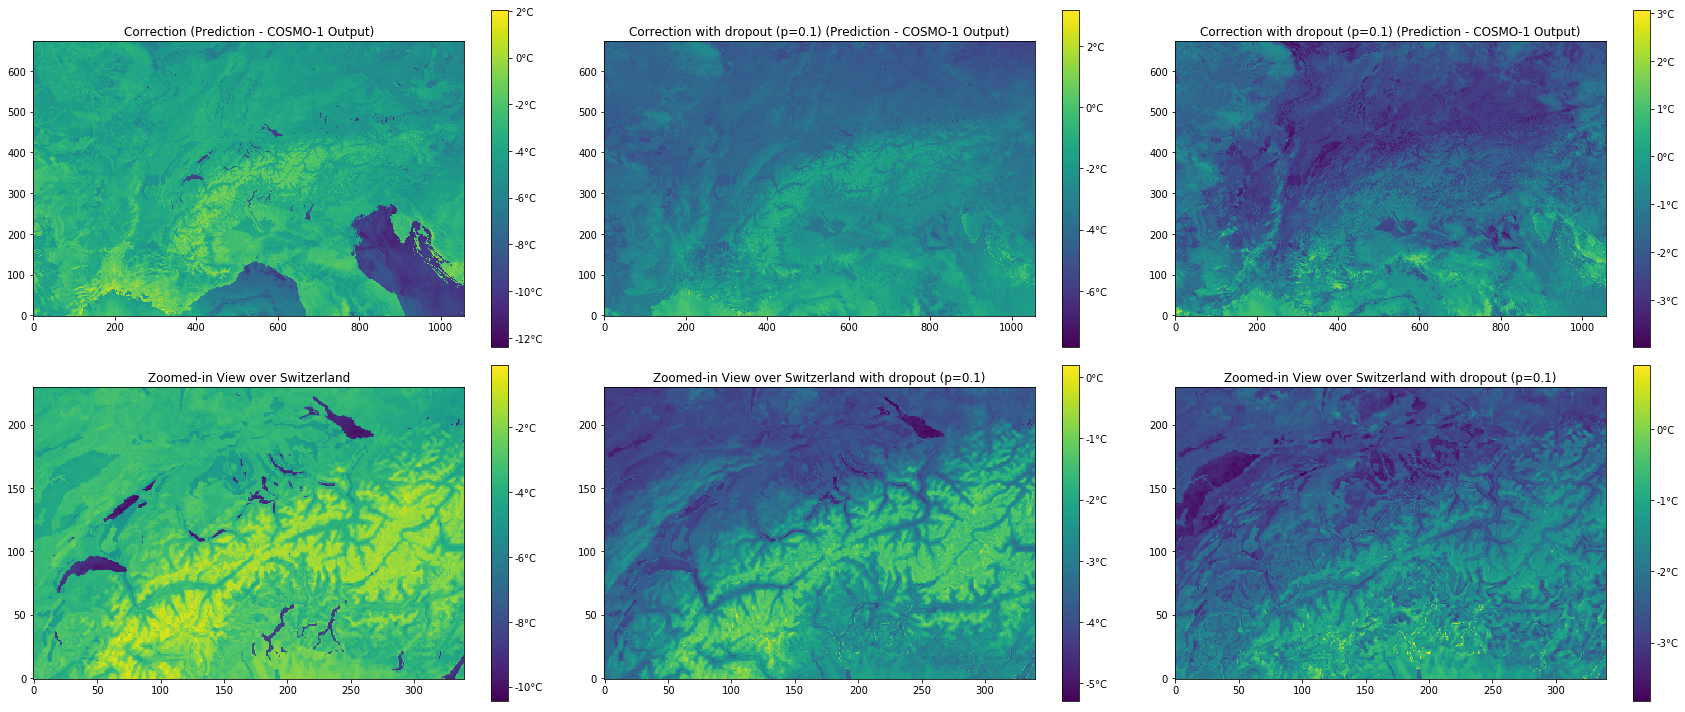

In [31]:
def format_dedree(x, pos=None):
    return "%s°C" % int(x)

n_parameter = len(ListParam)

    
out = network_output_wrapper(net, TestDataFlat).reshape((GridSizeLat, GridSizeLon))
out_dropout_0_1 = network_output_wrapper(net_dropout_0_1, TestDataFlat).reshape((GridSizeLat, GridSizeLon))
out_dropout_0_5 = network_output_wrapper(net_dropout_0_5, TestDataFlat).reshape((GridSizeLat, GridSizeLon))

plt.close('all')
#fig, axes = plt.subplot2grid((2,3), sharex=True, sharey=True, figsize=(16,4))

plt.figure(figsize=(24,10))
ax1 = plt.subplot2grid((2, 3), (0, 0))
ax2 = plt.subplot2grid((2, 3), (1, 0))
ax3 = plt.subplot2grid((2, 3), (0, 1))
ax4 = plt.subplot2grid((2, 3), (1, 1))
ax5 = plt.subplot2grid((2, 3), (0, 2))
ax6 = plt.subplot2grid((2, 3), (1, 2))

fig1 = ax1.imshow(out - TempForecast[init_idx])
fig2 = ax2.imshow((out - TempForecast[init_idx])[250:480,345:685])
fig3 = ax3.imshow(out_dropout_0_1 - TempForecast[init_idx])
fig4 = ax4.imshow((out_dropout_0_1 - TempForecast[init_idx])[250:480,345:685])
fig5 = ax5.imshow(out_dropout_0_5 - TempForecast[init_idx])
fig6 = ax6.imshow((out_dropout_0_5 - TempForecast[init_idx])[250:480,345:685])

plt.colorbar(fig1, ax=ax1, format=ticker.FuncFormatter(format_dedree))
plt.colorbar(fig2, ax=ax2, format=ticker.FuncFormatter(format_dedree))
plt.colorbar(fig3, ax=ax3, format=ticker.FuncFormatter(format_dedree))
plt.colorbar(fig4, ax=ax4, format=ticker.FuncFormatter(format_dedree))
plt.colorbar(fig5, ax=ax5, format=ticker.FuncFormatter(format_dedree))
plt.colorbar(fig6, ax=ax6, format=ticker.FuncFormatter(format_dedree))

ax1.invert_yaxis()
ax2.invert_yaxis()
ax3.invert_yaxis()
ax4.invert_yaxis()
ax5.invert_yaxis()
ax6.invert_yaxis()

# set titles
ax1.set_title("Correction (Prediction - COSMO-1 Output)")
ax2.set_title("Zoomed-in View over Switzerland")
ax3.set_title("Correction with dropout (p=0.1) (Prediction - COSMO-1 Output)")
ax4.set_title("Zoomed-in View over Switzerland with dropout (p=0.1)")
ax5.set_title("Correction with dropout (p=0.1) (Prediction - COSMO-1 Output)")
ax6.set_title("Zoomed-in View over Switzerland with dropout (p=0.1)")

plt.tight_layout()
plt.show()

# Backup (not used)

### Plot with cosmo output, model output, difference and close-up over Switzerland

In [ ]:
def format_dedree(x, pos=None):
    return "%s°C" % int(x)

n_parameter = len(ListParam)
IP2d_normalized = np.zeros_like(DATA[0])
for init_idx, IP2d in enumerate(DATA):
    print(folders[init_idx])
    for p_idx in range(n_parameter): IP2d_normalized[:,:,p_idx] = featureScaleFunctions[p_idx](IP2d[:,:,p_idx])

    # add temperature of lead time 0 (initial time of the model run) regardless to the lead time of the prediciton
    TEMP_T0_normalized = featureScaleFunctions[4](TEMP_T0[init_idx])
    GridData = np.concatenate((IP2d_normalized, TEMP_T0_normalized[...,None]), 2)


    TimeFeatures = TimeData[init_idx]
    TimeFeatures[:-1] = DataUtils.normalizeTimeFeatures(TimeFeatures[:-1])

    TimeInvGrid = time_inv_features.grid_data.sel(feature=['HH', 'HH_DIFF', 'FR_LAND', 'SOILTYP', 'LAT', 'LON', 'ABS_2D_DIST']).data
    TimeInvStation = time_inv_features.station_data.sel(station_feature=['height', 'lat', 'lon']).data
    
    GridData = np.concatenate((GridData, TimeInvGrid), 2)
    
    TestData = np.dstack((GridData, TimeInvStation, np.broadcast_to(TimeFeatures, (GridSizeLat,GridSizeLon,len(TimeFeatures)))))
    
    TestDataFlat = np.reshape(TestData, (-1,TestData.shape[2]))
    
    out = network_output_wrapper(net, TestDataFlat).reshape((GridSizeLat, GridSizeLon))

    
    plt.close('all')
    #fig, axes = plt.subplot2grid((2,3), sharex=True, sharey=True, figsize=(16,4))
    
    plt.figure(figsize=(14,8))
    ax1 = plt.subplot2grid((2, 2), (0, 0))
    ax2 = plt.subplot2grid((2, 2), (1, 0))
    ax3 = plt.subplot2grid((2, 2), (0, 1))
    ax4 = plt.subplot2grid((2, 2), (1, 1))
    
    fig1 = ax1.imshow(TempForecast[init_idx])
    fig2 = ax2.imshow(out)
    fig3 = ax3.imshow(out - TempForecast[init_idx])
    fig4 = ax4.imshow((out - TempForecast[init_idx])[250:480,345:685])
    
    plt.colorbar(fig1, ax=ax1, format=ticker.FuncFormatter(format_dedree))
    plt.colorbar(fig2, ax=ax2, format=ticker.FuncFormatter(format_dedree))
    plt.colorbar(fig3, ax=ax3, format=ticker.FuncFormatter(format_dedree))
    plt.colorbar(fig4, ax=ax4, format=ticker.FuncFormatter(format_dedree))
    
    ax1.invert_yaxis()
    ax2.invert_yaxis()
    ax3.invert_yaxis()
    ax4.invert_yaxis()
    
    # set titles
    ax1.set_title("COSMO-1 Output")
    ax2.set_title("Prediction")
    ax3.set_title("Correction (Prediction - COSMO-1 Output)")
    ax4.set_title("Zoomed in View of Correction over Switzerland")
    
    plt.tight_layout()
    plt.show()